# Code 10. DGL_pracetice: GraphSAGE

`from dgl.nn import SAGEConv`를 직접 구현하고, 이를 이용하여 GraphSAGE 모델을 학습시켜 봅니다.

In [2]:
import os
import sys

import time

import numpy as np

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
from dgl.data import CoraGraphDataset
import dgl.function as fn

Using backend: pytorch


In [3]:
'''
    Cora 데이터셋은 2708개의 논문(노드), 10556개의 인용관계(엣지)로 이루어졌습니다. 
    NumFeat은 각 노드를 나타내는 특성을 말합니다. 
    Cora 데이터셋은 각 노드가 1433개의 특성을 가지고, 개개의 특성은 '1'혹은 '0'으로 나타내어지며 특정 단어의 논문 등장 여부를 나타냅니다.
    즉, 2708개의 논문에서 특정 단어 1433개를 뽑아서, 1433개의 단어의 등장 여부를 통해 각 노드를 표현합니다.
    
    노드의 라벨은 총 7개가 존재하고, 각 라벨은 논문의 주제를 나타냅니다
    [Case_Based, Genetic_Algorithms, Neural_Networks, Probabilistic_Methods, Reinforcement_Learning, Rule_Learning, Theory]

    2708개의 노드 중, 학습에는 140개의 노드를 사용하고 모델을 테스트하는 데에는 1000개를 사용합니다.
    본 실습에서는 Validation을 진행하지않습니다.

    요약하자면, 앞서 학습시킬 모델은 Cora 데이터셋의 
    [논문 내 등장 단어들, 논문들 사이의 인용관계]를 활용하여 논문의 주제를 예측하는 모델입니다.
'''

# Cora Graph Dataset 불러오기
G = CoraGraphDataset()
numClasses = G.num_classes

G = G[0]
# 노드들의 feauture & feature의 차원
features = G.ndata['feat']
inputFeatureDim = features.shape[1]

# 각 노드들의 실제 라벨
labels = G.ndata['label']

# 학습/테스트에 사용할 노드들에 대한 표시
trainMask = G.ndata['train_mask']        
testMask = G.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [11]:
# 모델 학습 결과를 평가할 함수
def evaluateTrain(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def evaluateTest(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        macro_f1 = f1_score(labels, indices, average = 'macro')
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels), macro_f1

In [12]:
def train(model, lossFunction, features, labels, trainMask, optimizer, numEpochs):
    executionTime = []
    
    for epoch in range(numEpochs):
        model.train()

        startTime = time.time()
            
        logits = model(features)                                    # 포워딩
        loss = lossFunction(logits[trainMask], labels[trainMask])   # 모델의 예측값과 실제 라벨을 비교하여 loss 값 계산

        optimizer.zero_grad()                                       
        loss.backward()
        optimizer.step()

        executionTime.append(time.time() - startTime)

        acc = evaluateTrain(model, features, labels, trainMask)

        print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | Accuracy {:.4f}".format(epoch, np.mean(executionTime), loss.item(), acc))

def test(model, feautures, labels, testMask):
    acc, macro_f1 = evaluateTest(model, features, labels, testMask)
    print("Test Accuracy {:.4f}".format(acc))
    print("Test macro-f1 {:.4f}".format(macro_f1))

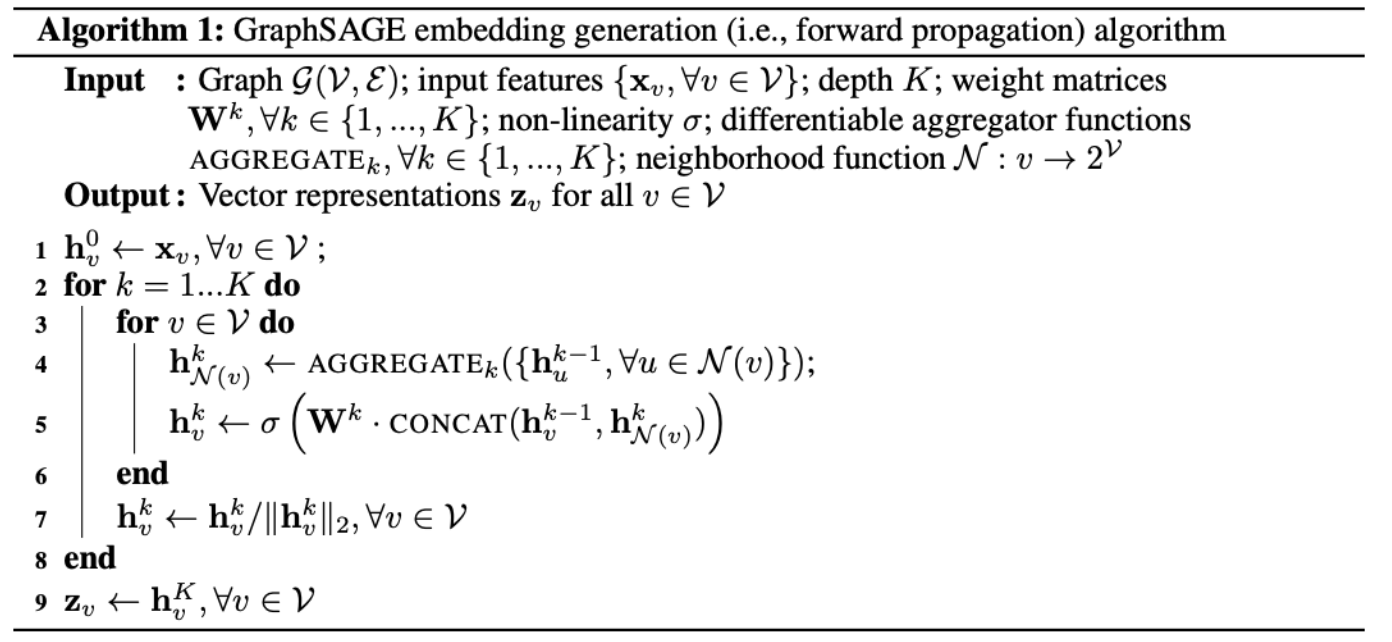

In [13]:
class SAGEConv(nn.Module):
    """
    in_feats: 인풋 feature의 사이즈
    out_feats: 아웃풋 feature의 사이즈
    activation: None이 아니라면, 노드 피쳐의 업데이트를 위해서 해당 activation function을 적용한다.
    """
    '''
        ref:
        https://arxiv.org/pdf/1706.02216.pdf 
        https://docs.dgl.ai/en/0.4.x/_modules/dgl/nn/pytorch/conv/sageconv.html
    '''
    
    def __init__(self, in_feats, out_feats, activation):
        super(SAGEConv, self).__init__()
        self._in_feats = in_feats # 입력 차원
        self._out_feats = out_feats # 출력 차원
        self.activation = activation # 활성화 함수

        self.W = nn.Linear(in_feats + in_feats, out_feats, bias = True) # 집계 과정 신경망, concat을 통해 차원이 2배가 되므로 in_feats + in_feats

    def forward(self, graph, feature):
        graph.ndata['h'] = feature # 그래프 데이터
        # dgl.function.sum: https://docs.dgl.ai/en/0.4.x/generated/dgl.function.sum.html?                                                
        graph.update_all(fn.copy_src('h', 'm'), fn.sum('m', 'neigh')) # h -> m 복사, sum -> neigh로 저장, fn.sum -> 이웃들 집계 함수로 예상됨
        # Aggregate & Noramlization
        degs = graph.in_degrees().to(feature) # 2708 정점에 대한 차수 계산
        hkNeigh = graph.ndata['neigh'] / degs.unsqueeze(-1) # 2708 정점에 대한 정보 / 차수
        hk = self.W(torch.cat((graph.ndata['h'], hkNeigh), dim = -1))
                
        if self.activation != None:
            hk = self.activation(hk)

        return hk

In [20]:
class GraphSAGE(nn.Module):
    '''
        graph               : 학습할 그래프
        inFeatDim           : 데이터의 feature의 차원
        numHiddenDim        : 모델의 hidden 차원
        numClasses          : 예측할 라벨의 경우의 수
        numLayers           : 인풋, 아웃풋 레이어를 제외하고 중간 레이어의 갯수
        activationFunction  : 활성화 함수의 종류
    '''
    def __init__(self, graph, inFeatDim, numHiddenDim, numClasses, numLayers, activationFunction):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.graph = graph

        # 인풋 레이어
        self.layers.append(
            SAGEConv(inFeatDim,
                     numHiddenDim,
                     activationFunction
                    ))
       
        # 히든 레이어
        for i in range(numLayers):
            self.layers.append(
                SAGEConv(numHiddenDim,
                         numHiddenDim,
                         activationFunction))
        
        # 출력 레이어
        self.layers.append(
            SAGEConv(numHiddenDim,
                     numClasses,
                     activation = None))

    def forward(self, features):
        x = features
        for layer in self.layers:
            x = layer(self.graph, x)
        return x

In [16]:
# 하이퍼파라미터 정의
learningRate = 1e-2
numEpochs = 50
numHiddenDim = 128
numLayers = 2
weightDecay = 5e-4

In [17]:
# 모델 생성
model = GraphSAGE(G,
                  inputFeatureDim,
                  numHiddenDim,
                  numClasses,
                  numLayers,
                  F.relu)
print(model)

lossFunction = torch.nn.CrossEntropyLoss()

# 옵티마이저 초기화
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learningRate,
                             weight_decay = weightDecay)

GraphSAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (W): Linear(in_features=2866, out_features=128, bias=True)
    )
    (1): SAGEConv(
      (W): Linear(in_features=256, out_features=128, bias=True)
    )
    (2): SAGEConv(
      (W): Linear(in_features=256, out_features=128, bias=True)
    )
    (3): SAGEConv(
      (W): Linear(in_features=256, out_features=7, bias=True)
    )
  )
)


In [18]:
train(model,
      lossFunction,
      features,
      labels,
      trainMask,
      optimizer,
      numEpochs)

Epoch 00000 | Time(s) 0.1699 | Loss 1.9463 | Accuracy 0.1429
Epoch 00001 | Time(s) 0.1254 | Loss 1.9467 | Accuracy 0.1429
Epoch 00002 | Time(s) 0.1093 | Loss 1.9445 | Accuracy 0.1500
Epoch 00003 | Time(s) 0.1010 | Loss 1.9415 | Accuracy 0.4000
Epoch 00004 | Time(s) 0.0956 | Loss 1.9313 | Accuracy 0.4714
Epoch 00005 | Time(s) 0.0924 | Loss 1.8990 | Accuracy 0.6571
Epoch 00006 | Time(s) 0.0901 | Loss 1.8183 | Accuracy 0.4571
Epoch 00007 | Time(s) 0.0885 | Loss 1.6505 | Accuracy 0.6286
Epoch 00008 | Time(s) 0.0863 | Loss 1.3918 | Accuracy 0.6500
Epoch 00009 | Time(s) 0.0853 | Loss 1.1326 | Accuracy 0.6357
Epoch 00010 | Time(s) 0.0843 | Loss 0.9327 | Accuracy 0.8929
Epoch 00011 | Time(s) 0.0838 | Loss 0.6069 | Accuracy 0.7857
Epoch 00012 | Time(s) 0.0831 | Loss 0.5083 | Accuracy 0.9357
Epoch 00013 | Time(s) 0.0824 | Loss 0.2919 | Accuracy 0.9286
Epoch 00014 | Time(s) 0.0818 | Loss 0.2069 | Accuracy 0.9643
Epoch 00015 | Time(s) 0.0814 | Loss 0.1358 | Accuracy 0.9929
Epoch 00016 | Time(s) 0.

In [19]:
test(model, features, labels, testMask)

Test Accuracy 0.7730
Test macro-f1 0.7665
